In [1]:
import pandas as pd
import matplotlib.pyplot as plt



In [2]:
import os
import json

os.makedirs("out", exist_ok=True)

report = {"hello": "world"}
with open("out/report.json", "w") as f:
    json.dump(report, f, indent=4)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

!unzip /content/drive/MyDrive/Teach_Foundation_of_ML/project/Regression/archive.zip

unzip:  cannot find or open /content/drive/MyDrive/Teach_Foundation_of_ML/project/Regression/archive.zip, /content/drive/MyDrive/Teach_Foundation_of_ML/project/Regression/archive.zip.zip or /content/drive/MyDrive/Teach_Foundation_of_ML/project/Regression/archive.zip.ZIP.


In [5]:

events=pd.read_csv('/content/drive/MyDrive/Assignment/events.csv',parse_dates=["ts"])

In [6]:
events.head(5)

,session_id,user_id,ts,event_name,device,app_id
0,S100000,U1081,2025-08-14 16:25:56,Loaded,mobile,app-0005-qugccoakchacom
1,S100000,U1081,2025-08-14 16:27:43,Interact,mobile,app-0005-qugccoakchacom
2,S100000,U1081,2025-08-14 16:29:20,Clicks,mobile,app-0005-qugccoakchacom
3,S100001,U1003,2025-09-01 21:10:12,Loaded,mobile,app-0021-armra
4,S100002,U1027,2025-08-05 20:03:24,Loaded,desktop,app-0005-qugccoakchacom


In [7]:
messages=pd.read_csv('/content/drive/MyDrive/Assignment/messages.csv',parse_dates=["ts"])

In [8]:
messages.head(5)

,session_id,ts,text,detected_intent
0,S100000,2025-08-14 16:26:14,Looking for options around $50,product_search
1,S100000,2025-08-14 16:26:58,How does A compare to B?,product_comparison
2,S100001,2025-09-01 21:11:20,Looking for options around $50,product_search
3,S100001,2025-09-01 21:12:50,Looking for options around $50,product_search
4,S100001,2025-09-01 21:13:05,Where is my order?,track_order


In [9]:
orders=pd.read_csv('/content/drive/MyDrive/Assignment/orders.csv', parse_dates=["created_at", "canceled_at"])

In [10]:
orders.head(5)

,order_id,session_id,created_at,canceled_at,order_value
0,O247400,S100002,2025-08-05 20:18:43,NaT,49.64
1,O283886,S100004,2025-08-23 08:32:13,NaT,89.44
2,O200942,S100014,2025-08-16 11:24:41,2025-08-16 14:22:41,109.69
3,O241180,S100022,2025-08-13 07:09:05,NaT,42.44
4,O261069,S100044,2025-08-24 20:48:27,NaT,85.80


1) FUNNEL CONVERSION

In [11]:
funnel_steps = ["Loaded", "Interact", "Clicks", "Purchase"]

In [12]:
# Count unique users per step & device
funnel = (
    events[events["event_name"].isin(funnel_steps)]
    .groupby(["device", "event_name"])["user_id"]
    .nunique()
    .reset_index(name="users")
)

In [13]:
# Ensure proper step order
funnel["step_order"] = funnel["event_name"].map(
    {s: i for i, s in enumerate(funnel_steps, 1)}
)
funnel = funnel.sort_values(["device", "step_order"])

In [14]:
# Calculate conversion %
funnel["conv_from_start_pct"] = (
    funnel.groupby("device")["users"].transform(lambda x: 100 * x / x.iloc[0])
).round(2)

funnel["conv_from_prev_pct"] = (
    funnel.groupby("device")["users"].pct_change().add(1).mul(100).round(2)
)

funnel_out = funnel[["event_name", "users", "conv_from_prev_pct", "conv_from_start_pct", "device"]]
funnel_out = funnel_out.rename(columns={"event_name": "step"}).to_dict(orient="records")


2) INTENT DISTRIBUTION

In [15]:
# Clean intents
messages["detected_intent"] = (
    messages["detected_intent"].fillna("").str.strip().replace("", "unknown")
)

intent_counts = (
    messages.groupby("detected_intent")["session_id"]
    .count()
    .reset_index(name="count")
)

total_msgs = intent_counts["count"].sum()
intent_counts["pct_of_total"] = (intent_counts["count"] / total_msgs * 100).round(2)

intents_out = intent_counts.rename(columns={"detected_intent": "intent"}).to_dict(orient="records")


In [16]:
# Correlation with purchase
purchase_sessions = set(events.loc[events["event_name"] == "Purchase", "session_id"])
messages["is_purchase"] = messages["session_id"].isin(purchase_sessions)

intent_purchase_corr = (
    messages.groupby("detected_intent")["is_purchase"]
    .sum()
    .reset_index(name="purchase_sessions")
    .sort_values("purchase_sessions", ascending=False)
)

top2_intents_purchase = intent_purchase_corr.head(2)


# 3) CANCELLATION SLA

In [17]:
orders["is_canceled"] = orders["canceled_at"].notna()
orders["is_violation"] = (
    orders["is_canceled"]
    & ((orders["canceled_at"] - orders["created_at"]).dt.total_seconds() > 3600)
)

cancellation_sla = {
    "total_orders": len(orders),
    "canceled": int(orders["is_canceled"].sum()),
    "violations": int(orders["is_violation"].sum()),
    "violation_rate_pct": round(
        100 * orders["is_violation"].sum() / max(orders["is_canceled"].sum(), 1), 2
    ),
}

# SAVE JSON REPORT

In [18]:
report = {
    "funnel": funnel_out,
    "intents": intents_out,
    "cancellation_sla": cancellation_sla,
}

# Create the 'out' directory if it doesn't exist
os.makedirs("out", exist_ok=True)

with open("out/report.json", "w") as f:
    json.dump(report, f, indent=4)

# CHARTS

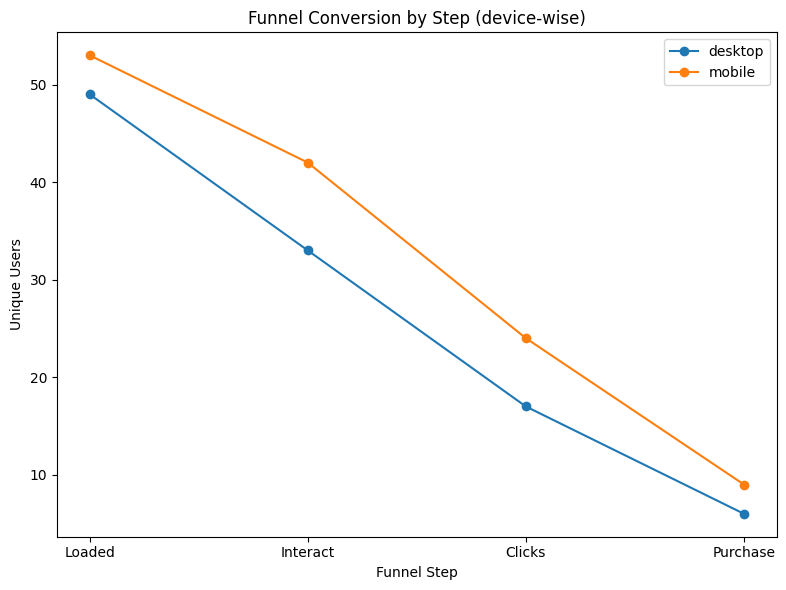

In [21]:
# Funnel Chart (grouped by device)
plt.figure(figsize=(8, 6))
for device, group in funnel.groupby("device"):
    plt.plot(group["step_order"], group["users"], marker="o", label=device)

plt.xticks(range(1, len(funnel_steps) + 1), funnel_steps)
plt.xlabel("Funnel Step")
plt.ylabel("Unique Users")
plt.title("Funnel Conversion by Step (device-wise)")
plt.legend()
plt.tight_layout()
plt.savefig("out/funnel.png")
plt.show()
plt.close()

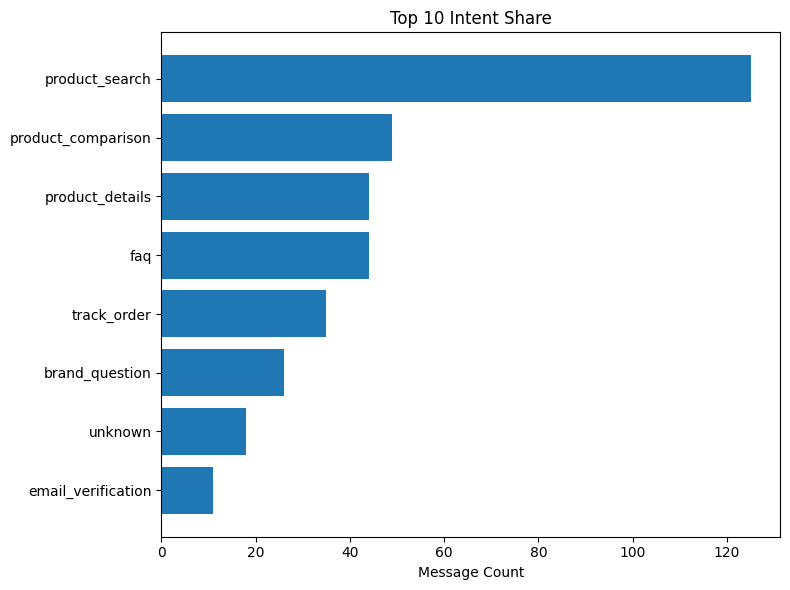

✅ Report and charts generated in /out


In [22]:
# Intent Share (Top 10)
top10_intents = intent_counts.sort_values("count", ascending=False).head(10)

plt.figure(figsize=(8, 6))
plt.barh(top10_intents["detected_intent"], top10_intents["count"])
plt.xlabel("Message Count")
plt.title("Top 10 Intent Share")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("out/intents.png")
plt.show()
plt.close()

print("✅ Report and charts generated in /out")